In [97]:
import numpy as np
import pybrain

In [98]:
from PIL import Image, ImageDraw, ImageFont

In [99]:
from skimage import transform as tf

In [100]:
%matplotlib inline

In [101]:
from matplotlib import pyplot as plt

In [102]:
from skimage.measure import label, regionprops
from sklearn.utils import check_random_state
random_state = check_random_state(14)
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0,0.5,0.05)
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from pybrain.datasets import SupervisedDataSet
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from sklearn.metrics import f1_score

CREATE CAPTCHA


In [103]:
def create_captcha(text, shear=0, size=(100,24)):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"Coval.otf", 22)
    draw.text((2, 2), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    return image/image.max()

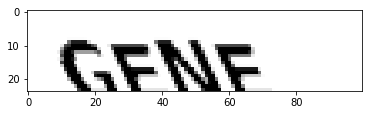

In [104]:
image = create_captcha("GENE",shear=0.5)
plt.imshow(image,cmap='Greys')

SEGMENT CAPTCHA

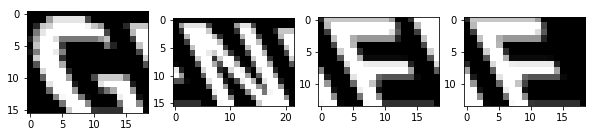

In [105]:
def segment_image(image):
    labeled_image = label(image>0)
    subimages = []
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, en_y = region.bbox
        subimages.append(image[start_x:end_x,start_y:en_y])
    if len(subimages) == 0:
        return  [image,]
    return subimages
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages),figsize=(10,3))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

DATASET RECONIZE EACH LETTER


The target for this image is: 11


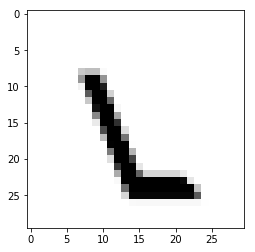

In [106]:
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    return create_captcha(letter,shear=shear,size=(30,30)),letters.index(letter)

image, target = generate_sample(random_state)
plt.imshow(image,cmap="Greys")
print("The target for this image is: {0}".format(target))
dataset, targets = zip(*(generate_sample(random_state)for i in range(3000)))
dataset= np.array(dataset, dtype='float')
targets = np.array(targets)

In [107]:
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))
y = y.todense()

C:\Users\sandr\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [111]:
dataset = np.array([resize(segment_image(sample)[0],(20,20))for sample in dataset])
X = dataset.reshape((dataset.shape[0], dataset.shape[1]*dataset.shape[2]))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

NEURAL NETWORK TAKE THE IMAGE AS INPUT

In [112]:
training = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_train.shape[0]):
    training.addSample(X_train[i], y_train[i])
testing = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_test.shape[0]):
    testing.addSample(X_test[i], y_test[i])

net = buildNetwork(X.shape[1],100,y.shape[1], bias=True)




BACKPROPAGATION

In [114]:
trainer = BackpropTrainer(net,training,learningrate=0.01, weightdecay=0.01)
trainer.trainEpochs(epochs=20)
predictions = trainer.testOnClassData(dataset=testing)
print ("F-score: {0:.2f}".format(f1_score(predictions, y_test.argmax(axis=1))))

ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [ ]:
print("hola mundo")

PREDICTING WORDS